# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Download the Dataset

In [2]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 49.1MB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [3]:
df = pd.read_csv('/content/spam.csv')

df.head(5)

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [4]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


2 class

# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.isnull().sum()

,0
text,0
label,0


Text(0, 0.5, 'Label')

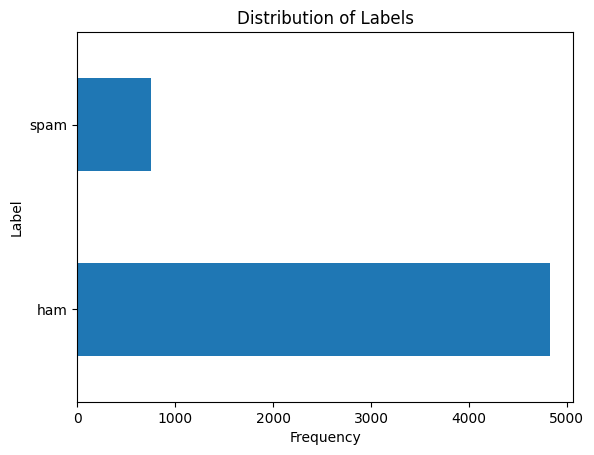

In [7]:
lable_dis = df['label'].value_counts()
lable_dis.plot(kind='barh')
plt.title('Distribution of Labels')
plt.xlabel('Frequency')
plt.ylabel('Label')

its imbalanced data, and The ham class is higher than spam

count    5572.000000
mean       15.994078
std        11.332548
min         1.000000
25%         8.000000
50%        13.000000
75%        23.000000
max       171.000000
Name: text_length, dtype: float64


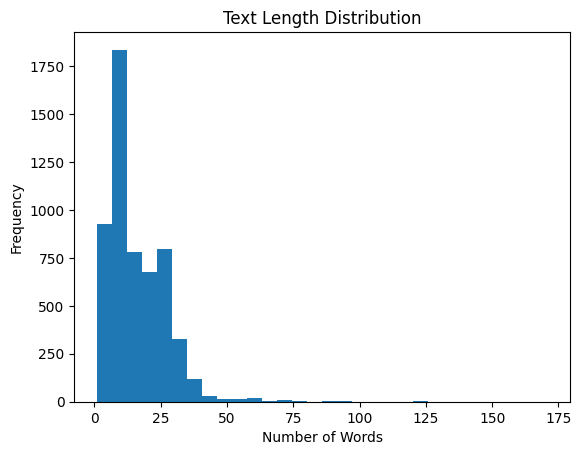

In [8]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

print(df['text_length'].describe())

df['text_length'].plot(kind='hist', bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

This is to analyze the distribution of the text column and to determine the frequency of words. The majority of the text contains between 1 to 27 words, and more than 1750 rows have the same number of words.   
I hope I have provided a good explanation for this graph.

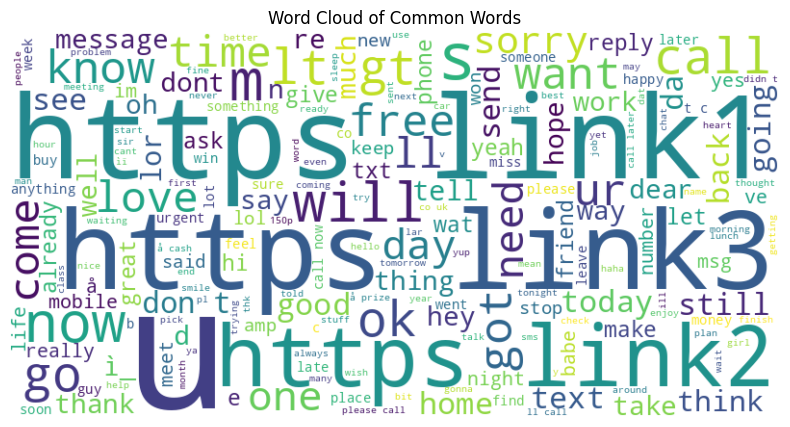

In [9]:
from wordcloud import WordCloud

def tokenize(text):
    words = re.findall(r'\b\w+\b', str(text).lower())
    return words

all_words = df['text'].apply(tokenize).explode()
all_words = all_words.dropna()
all_words_string = ' '.join(all_words)

# Wordcloud to know the common word
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_string)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words')
plt.show()

The best graph to know common word is the Word cloud, the big word mean has more repeated then other, the opposite for small one.  
  
https the commen one

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
# function to do all preprocessing I need , I make it like this to be easy if I need it again call the method, also its cool and easy to add more if i want more..

def process_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stopwords
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


In [13]:
df['text'] = df['text'].apply(process_text)

df

,text,label,text_length
0,Go jurong point crazy Available bugis n great ...,ham,20
1,Ok lar Joking wif u oni,ham,6
2,Free entry 2 wkly comp win FA Cup final tkts 2...,spam,29
3,U dun say early hor U c already say,ham,12
4,Nah dont think go usf life around though,ham,14
...,...,...,...
5567,2nd time tried 2 contact u U å750 Pound prize ...,spam,31
5568,Ì_ b going esplanade fr home,ham,8
5569,Pity mood Soany suggestion,ham,11
5570,guy bitching acted like id interested buying s...,ham,26


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [14]:
# Define Voba size from length for Tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

vocab_size = len(tokenizer.word_index) + 1  # padding

In [15]:
max_length = max(len(seq) for seq in sequences)  # or set a fixed length like 200
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [17]:
from imblearn.over_sampling import SMOTE

label_encoder = LabelEncoder() # for lable
encoded_labels = label_encoder.fit_transform(df['label'])

# spilt datasets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42 )
#  imbalanced data so do SMOTE to deal with it
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
print(f'Training data shape: {X_resampled.shape}, Training labels shape: {y_resampled.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (7720, 80), Training labels shape: (7720,)
Testing data shape: (1115, 80), Testing labels shape: (1115,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [19]:
# RNN model

model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.Input(shape=(max_length,)),
    # embedding layer
    tf.keras.layers.Embedding(vocab_size, 64),
    # Bidirectional layer
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64, return_sequences=False)),
    # layer 1
    tf.keras.layers.Dense(64, activation='relu'),
    # layer 2
    tf.keras.layers.Dense(32, activation='relu'),
    # output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 80, 64)              │         575,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601,985 (2.30 MB)

 Trainable params: 601,985 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [22]:
# i make it 10 to be fast in runing
batch_size = 30

In [23]:
# create data
train_dataset = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [24]:
# fit model
history = model.fit(
    train_dataset,
    epochs=8,
    validation_data=test_dataset,
)

Epoch 1/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9005 - loss: 0.2505 - val_accuracy: 0.1345 - val_loss: 7.3012
Epoch 2/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.8063 - loss: 0.6380 - val_accuracy: 0.1354 - val_loss: 4.2651
Epoch 3/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.8868 - loss: 0.3411 - val_accuracy: 0.1345 - val_loss: 8.2472
Epoch 4/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8078 - loss: 0.8002 - val_accuracy: 0.1345 - val_loss: 5.0312
Epoch 5/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8055 - loss: 0.6491 - val_accuracy: 0.1489 - val_loss: 5.3990
Epoch 6/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8414 - loss: 0.5253 - val_accuracy: 0.3211 - val_loss: 3.2743
Epoch 7/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9187 - loss: 0.2654 - val_accuracy: 0.3399 - val_loss: 2.7896
Epoch 8/8
258/258 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9436 - loss: 0.1591 - val_accu

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

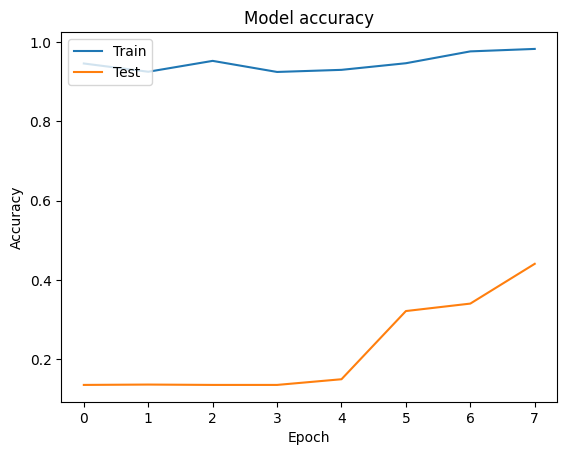

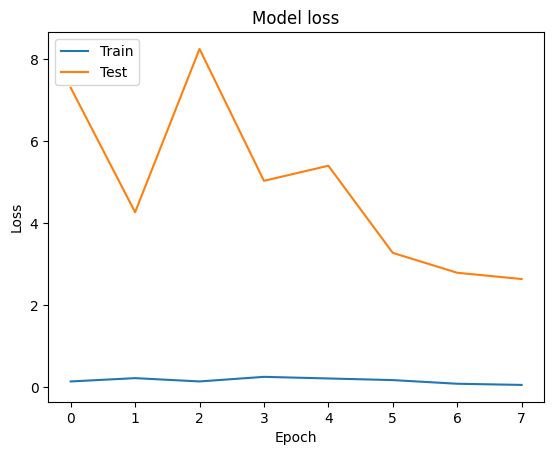

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [26]:
sample_text = (
    '''Hurry up, there is a 94% discount for the National Day of Saudi Arabia.
    Enter this link to avail the discount, or your mark will be discounted.'''
)

In [27]:
# Tokenize sample and make a psd to pridict
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts([sample_text])  # Fitting on the sample text to tokenize
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post')

In [28]:
# Make prediction
predictions = model.predict(sample_padded)
print(*predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
0.9152683


In [29]:
# prediction
if predictions[0] > 0:
    print('spam message')
else:
    print('ham message')

spam message


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

'''
1-  make a def easy call and add more preprocessing, into def I remove URL, stopwords, punctuation, and Lemmatization (Lemmatization to return word to original)  
2- first I tried to make 4 layers but it overfitted, then I tried 1 also the same, if I want to avoid overfitting, then i deal with imbalanced data by SMOTE but alos give me overfitting results ...   
3- try  
4- popular  
5- overfitting (accuracy 0.94, val_accuracy 0.44)  
6- i deal with imbalanced but the same before and after all have overfitting, so if i want to fix i think try another method dealing with imbalanced dataset, or add more datasetes.   
'''